# ELO Evaluation

In the notebook we are going to be taking a closer look into the ELO metric. We will be looking intoo our games_manipulated data to dive into evaluated this metric. 

We are going to checking: 
1. [**Completeness:**](#section1) how complete this data point is in our dataset
2. [**Reliability:**](#section2) how reliable of a metric is to help us evaluate the performance of a college team. 
3. [**Trending ELO:**](#section3) Trend out the ELO rating and evaluate how well of a job it does in particular seasons 

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import altair as alt


### 1. Completeness

<a id='section1'></a>

In [2]:
df = pd.read_csv('../data/games_manipulated.csv', low_memory=False)
df.head() 

,Unnamed: 0,index,id,season,week,season_type,start_date,start_time_tbd,completed,neutral_site,...,points_against,point_differential,team_line_scores,opposing_line_scores,team_pregame_elo,team_postgame_elo,opponent_pregame_elo,opponent_postgame_elo,win_flag,game_that_season
0,0,1,400763593,2015,1,regular,2015-09-03T22:00:00.000Z,NaN,True,False,...,15.0,-1.0,"[7, 7, 0, 0]","[3, 0, 6, 6]",1626.0,1609.0,1321.0,1338.0,0,1
1,1,323,400764868,2015,3,regular,2015-09-19T22:00:00.000Z,False,True,False,...,16.0,-1.0,"[7, 5, 3, 0]","[0, 7, 6, 3]",NaN,NaN,NaN,NaN,0,3
2,2,656,400764884,2015,6,regular,2015-10-10T19:45:00.000Z,NaN,True,False,...,40.0,-27.0,"[3, 0, 0, 10]","[9, 14, 17, 0]",1460.0,1360.0,1262.0,1362.0,0,6
3,3,820,400764895,2015,8,regular,2015-10-24T16:00:00.000Z,NaN,True,False,...,59.0,-49.0,"[7, 3, 0, 0]","[7, 17, 28, 7]",1356.0,1255.0,1712.0,1813.0,0,8
4,4,1276,400764911,2015,12,regular,2015-11-20T00:30:00.000Z,NaN,True,False,...,44.0,-37.0,"[7, 0, 0, 0]","[14, 17, 13, 0]",1147.0,1082.0,1479.0,1544.0,0,11


In [3]:
## Check Missingness 
percent_missing = round(df['team_pregame_elo'].isnull().sum()  / df['team_pregame_elo'].shape[0], 2)
print(f'Peercent of ELO that are missing: {percent_missing}')

Peercent of ELO that are missing: 0.62


In [4]:
# Get the missing rate and count of games 
result_df = df.groupby(['game_that_season', 'season']).agg(
    percent_missing=('team_pregame_elo', lambda x: (x.isnull().mean()) * 100),
    count=('team_pregame_elo', 'count')
).reset_index()


result_df.head(19) 

,game_that_season,season,percent_missing,count
0,1,2015,72.013652,82
1,1,2016,71.768707,83
2,1,2017,68.835616,91
3,1,2018,70.469799,88
4,1,2019,69.636964,92
5,1,2020,24.675325,116
6,1,2021,78.310502,95
7,1,2022,80.847953,131
8,1,2023,80.612245,133
9,2,2015,59.143969,105


<Axes: xlabel='game_that_season', ylabel='percent_missing'>

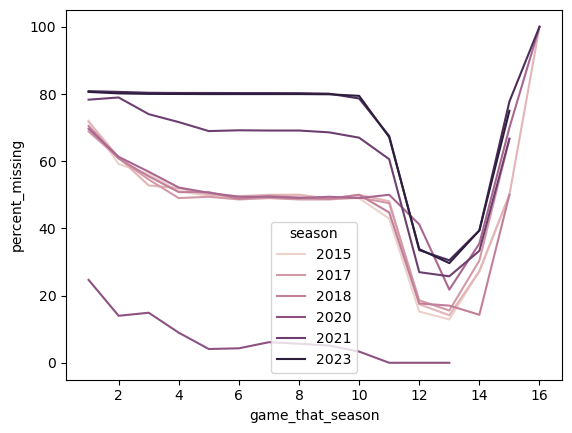

In [5]:
# Shows that we tend to see moroe missing NLOs around the 12-14 games 
# Also notice that 2020 had a lot less games, and some other years also had less games
sns.lineplot(result_df, x='game_that_season', y='percent_missing' , hue='season')

<Axes: xlabel='game_that_season', ylabel='count'>

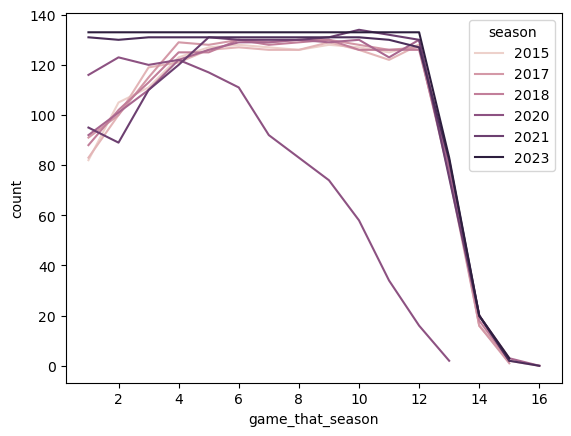

In [6]:
# Show the distribution of games across years
sns.lineplot(result_df, x='game_that_season', y='count' , color='grey', hue='season')

In [7]:
## When does this missingness happen? 
power_5_conf = ['Pac-12', 'Big 12', 'ACC', 'SEC', 'Big Ten']

# team_conference
team_conference = df[df['team_conference'].isin(power_5_conf)]

team_conference.groupby(['season']).agg(
    percent_missing=('team_pregame_elo', lambda x: (x.isnull().mean()) * 100),
    count=('team_pregame_elo', 'count')
).reset_index().sort_values(by='season')

 

,season,percent_missing,count
0,2015,6.067961,774
1,2016,5.968331,772
2,2017,5.237515,778
3,2018,5.839416,774
4,2019,6.090134,771
5,2020,1.578947,561
6,2021,5.731707,773
7,2022,0.121803,820
8,2023,0.000000,874


Teams in the Power 5 conference have a higher completion rate for the ELO rating.

In [8]:
cols = ['season', 'game_that_season', 'season_type','team_id', 'team_conference','main_team','opposing_team_id','conference_game','team_postgame_elo', 'team_pregame_elo', 'win_flag']

filtered_df = df[cols]

# Show games in 13 games 
filtered_df = filtered_df[filtered_df['game_that_season'] == 12]
filtered_df = filtered_df[filtered_df['team_conference'].isin(power_5_conf)]
filtered_df = filtered_df[filtered_df['season'] != 2020] # outliar

filtered_df.rename(columns={'season':'year', 'main_team': 'school'},inplace=True)

filtered_df.head()

,year,game_that_season,season_type,team_id,team_conference,school,opposing_team_id,conference_game,team_postgame_elo,team_pregame_elo,win_flag
56,2023,12,regular,2116,Big 12,UCF,248,True,1658.0,1648.0,1
120,2015,12,regular,2579,SEC,South Carolina,228,False,1579.0,1561.0,0
135,2017,12,regular,2579,SEC,South Carolina,228,False,1572.0,1586.0,0
142,2018,12,regular,2579,SEC,South Carolina,2006,False,1641.0,1627.0,1
149,2019,12,regular,2579,SEC,South Carolina,228,False,1497.0,1501.0,0


In [9]:
# Number of null values 
filtered_df['team_postgame_elo'].isna().sum() 

1

### 2. Reliability
<a id='section2'></a>

In [10]:
df_teams = pd.read_csv('../data/teams.csv')
df_teams.head() 

,Unnamed: 0,id,school,conference,division,color,logos
0,0,2005,Air Force,Mountain West,Mountain,#004a7b,http://a.espncdn.com/i/teamlogos/ncaa/500/2005...
1,1,2006,Akron,Mid-American,East,#00285e,http://a.espncdn.com/i/teamlogos/ncaa/500/2006...
2,2,333,Alabama,SEC,West,#690014,http://a.espncdn.com/i/teamlogos/ncaa/500/333.png
3,3,2026,Appalachian State,Sun Belt,East,#000000,http://a.espncdn.com/i/teamlogos/ncaa/500/2026...
4,4,12,Arizona,Pac-12,NaN,#002449,http://a.espncdn.com/i/teamlogos/ncaa/500/12.png


In [11]:
df = pd.read_csv('../data/games_manipulated.csv')

# Filter to only the power 5 conference week 12
power_5_conf = ['Pac-12', 'Big 12', 'ACC', 'SEC', 'Big Ten']
df = df[df['team_conference'].isin(power_5_conf)]
df = df[df['game_that_season'] == 12] # Final game of reg season

# Bring in only necessarry columns
df = df[['season', 'team_id', 'main_team', 'team_postgame_elo', 'team_conference']]

/var/folders/wp/393dmtxd2jd8sj2z2tt7jpm40000gn/T/ipykernel_33839/3363136701.py:1: DtypeWarning: Columns (7,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/games_manipulated.csv')


In [12]:
final_df = pd.merge(left = df, right = df_teams, left_on = 'team_id', right_on = 'id')

# final_df = final_df[['season', 'team_conference', 'team_postgame_elo', 'main_team', 'logos']]
final_df.head() 

,season,team_id,main_team,team_postgame_elo,team_conference,Unnamed: 0,id,school,conference,division,color,logos
0,2023,2116,UCF,1658.0,Big 12,113,2116,UCF,Big 12,NaN,#000000,http://a.espncdn.com/i/teamlogos/ncaa/500/2116...
1,2015,2579,South Carolina,1579.0,SEC,96,2579,South Carolina,SEC,East,#670010,http://a.espncdn.com/i/teamlogos/ncaa/500/2579...
2,2017,2579,South Carolina,1572.0,SEC,96,2579,South Carolina,SEC,East,#670010,http://a.espncdn.com/i/teamlogos/ncaa/500/2579...
3,2018,2579,South Carolina,1641.0,SEC,96,2579,South Carolina,SEC,East,#670010,http://a.espncdn.com/i/teamlogos/ncaa/500/2579...
4,2019,2579,South Carolina,1497.0,SEC,96,2579,South Carolina,SEC,East,#670010,http://a.espncdn.com/i/teamlogos/ncaa/500/2579...


In [13]:
alt.Chart(final_df).mark_image(opacity = .90, width = 20, height = 20).encode(
    
    x = alt.X('team_postgame_elo', title = 'ELO Rating at Season End', scale=alt.Scale(domain=[800, 2500])), 
                                y = alt.Y('team_conference', title = 'Conference'),
                                tooltip = ['main_team', 'team_postgame_elo'],
                                url = 'logos'
                               ).properties(height = 250, width = 300)\
.facet(facet = 'season:O', columns = 3).properties(title = 'End of Regular Season ELO Rating: 2013 - 2023')

alt.FacetChart(...)

### 3. Trending ELO 
<a id='section3'></a>

In [14]:
df = pd.read_csv('../data/games_manipulated.csv')

# Filter to only the power 5 conference, regular season
power_5_conf = ['Pac-12', 'Big 12', 'ACC', 'SEC', 'Big Ten']
df = df[df['team_conference'].isin(power_5_conf)]
df = df[df['season_type'] == 'regular']

# Join on to teams dataset for team logos and color
final_df = pd.merge(left = df, right = df_teams, left_on = 'team_id', right_on = 'id')

# Bring in only necessarry columns
final_df = final_df[['season', 'team_id', 'main_team', 'game_that_season','team_postgame_elo', 'team_conference', 'logos', 'color']]

/var/folders/wp/393dmtxd2jd8sj2z2tt7jpm40000gn/T/ipykernel_33839/3538676945.py:1: DtypeWarning: Columns (7,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/games_manipulated.csv')


In [15]:
power_5_conf = ['Pac-12', 'Big 12', 'ACC', 'SEC', 'Big Ten']

season = 2023
conference = 'Big Ten'

smaller_df = final_df[final_df['season'] == season]
smaller_df = smaller_df[smaller_df['team_conference'] == conference]

line = alt.Chart(smaller_df).mark_line(opacity = .8).encode(
    x = alt.X('game_that_season', title = 'Week'),
    y = alt.Y('team_postgame_elo', scale=alt.Scale(domain=[1000, 2500]), title = 'Post Game ELO'),
    color = alt.Color('color:N').scale(None)).properties(
    height = 400, width = 400, title = 'Trend in End of Game ELO Season')

dot_df = smaller_df[smaller_df['game_that_season'].isin([1,12])]

logos = alt.Chart(dot_df).mark_image(opacity = .95, width = 30, height = 30).encode(
        x = alt.X('game_that_season'),
        y = alt.Y('team_postgame_elo'),
        url = 'logos')

line + logos

alt.LayerChart(...)